## time dynamics

In [2]:
# imports

import numpy as np
import pandas as pd
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import itertools
import random
# import pygwalker as pyg
import seaborn as sns
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.d03_processing.BlinkProcessor import BlinkProcessor
from src.d03_processing.fixations.SignalProcessor import SignalProcessor
from src.d03_processing.fixations.I_VDT import I_VDT
from src.d00_utils.TaskObjects import *
from src.d03_processing.fixations.FixationProcessor import FixationProcessor
from src.d03_processing.TimepointProcessor import TimepointProcessor
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d01_data.fetch.fetch_viewings import fetch_viewings
from src.d01_data.fetch.fetch_trials import fetch_trials
from src.d03_processing.aoi import collision_sphere_radius
from src.d03_processing.feature_extract.to_viewing import to_viewing
from src.d03_processing.fixations.FixAlgos import *
from src.d03_processing.feature_calculate.viewing_compare_calcs import ea_td
from src.d03_processing.preprocess import preprocess_timepoints
from src.d04_wrangling.add_ppt_info import get_ppts_by_group

import pickle

In [4]:
def upsample_1d_string(inputs, timestamps, new_interval):
    inputs = np.array(inputs)
    # print(inputs[:10])
    timestamps = np.array(timestamps)
    timestamps -= timestamps[0]
    output_size = timestamps[-1]
    output = np.empty(output_size, dtype='object')
    for i in range(len(timestamps)-1):
        start = timestamps[i]
        end = timestamps[i + 1]
        mid = int(np.ceil((start + end) / 2))
        output[start:mid] = str(inputs[i])
        output[mid:end] = inputs[i + 1]
    output[timestamps[-1]:] = inputs[-1]
    return output

In [3]:
# data - 1 ppt first
# old_pids = ['37', '38', '39', '40', '42', '44']
# young_pids = ['13', '12', '14', '15', '16', '17']
# mci_pids = ['50', '51', '52', '53', '57', '58']

pids_dict = get_ppts_by_group()
young_pids = pids_dict['Younger']
old_pids = pids_dict['Older']
mciu_pids = pids_dict['MCIu']
mcineg_pids = pids_dict['MCI-']
mcipos_pids = pids_dict['MCI+']
print(mciu_pids)
cutoff = 7000   # ms
pid_groups = [young_pids, old_pids, mciu_pids, mcineg_pids, mcipos_pids]
group_names = ['Younger', 'Older', 'MCIu', 'MCI-', 'MCI+']
view_type = 'enc'
ret_epochs = ['na', 'view']
aoi_names = ['moved', 'selected', 'previous', 'external', 'table', 'obj2', 'obj3', 'obj4', 'notselect_2', 'notselect_3', 'notselect_4']

['alloeye_79', 'alloeye_80', 'alloeye_81', 'alloeye_82', 'alloeye_83', 'alloeye_84', 'alloeye_85', 'alloeye_86', 'alloeye_87', 'alloeye_88', 'alloeye_89', 'alloeye_90', 'alloeye_103', 'alloeye_104', 'alloeye_105', 'alloeye_106', 'alloeye_107', 'alloeye_108', 'alloeye_109', 'alloeye_110', 'alloeye_111', 'alloeye_112', 'alloeye_113', 'alloeye_114', 'alloeye_115', 'alloeye_116', 'alloeye_117', 'alloeye_118', 'alloeye_119', 'alloeye_120', 'alloeye_121', 'alloeye_122', 'alloeye_123', 'alloeye_124', 'alloeye_125', 'alloeye_126', 'alloeye_127', 'alloeye_128', 'alloeye_129', 'alloeye_130']


In [9]:
axes = []
grouped_all_ps = []
for p in range(len(pid_groups)):
    pids = pid_groups[p]
    
    # lists of saving areas of interest data
    moved_p, selected_p, previous_p, external_p, table_p, obj2_ps, obj3_ps, obj4_ps, ns_obj2_ps, ns_obj3_ps, ns_obj4_ps = [], [], [], [], [], [], [], [], [], [], []
    all_ps = [moved_p, selected_p, previous_p, external_p, table_p, obj2_ps, obj3_ps, obj4_ps,  ns_obj2_ps, ns_obj3_ps, ns_obj4_ps]
    
    for pid in pids:
        # pid = '39'
        print(pid)
        timepoints = fetch_timepoints(pid, viewing_type=view_type, ret_epochs=ret_epochs, suppress_print=True)
        trials = fetch_trials(pid)
        p_tps = []
        viewings = list(np.unique(timepoints.viewing_id))
        n_viewings = len(viewings)
        
        # preprocess
        for i in range(n_viewings):
            # ind = random.randint(0, len(viewings)-1)
            viewing = viewings[i]
            # viewing = "alloeye_52r2_17_ret"
            # print(viewing)

            # print(viewing)
            tps = timepoints[timepoints.viewing_id == viewing].reset_index(drop=True)
            f_tps, skip = preprocess_timepoints(tps)
            if skip:
                p_tps.append(None)
                
            p_tps.append(f_tps)
        
        # up sample and normalise time period
        up_objects = []
        max_t = 0
        min_t = 10000
        val_n_viewings = n_viewings
        for i in range(n_viewings):
            if p_tps[i] is None:
                val_n_viewings -= 1
                continue
            t = p_tps[i].eye_timestamp_ms.to_numpy()
            end_t = np.max(t) - np.min(t)
            if end_t > max_t:
                max_t = end_t
            if end_t < min_t:
                min_t = end_t
            up_t = SignalProcessor(None, t).up_t(1)
            object_array = p_tps[i].gaze_object
            pd.options.mode.chained_assignment = None  # default='warn'
            object_array[p_tps[i].missing == True] = None  # account for missingness
            upped_object= upsample_1d_string(object_array, t, 1)
            up_objects.append(upped_object)
        # print(p_tps)
        print("number of valid viewings: ", val_n_viewings)
        if val_n_viewings < 2:
            continue
        # print(len(up_objects))
        # print(max_t)
        # print(min_t)

        df = pd.DataFrame()
        t = np.arange(0, max_t)
        df['t'] = t
        # print(len(t))
        for i in range(val_n_viewings):
            upped = up_objects[i]
            up_len = len(upped)
            # print(up_len)
            if up_len < max_t:
                none_len = max_t - up_len
                # print(none_len)
                up_objects[i] = np.append(up_objects[i], np.empty(none_len, dtype='object'))
            # print(f'v{i}_obj')
            df[f'v{i}_obj'] = up_objects[i]


        # display(df.head(1).style)
        # check for duplicate columns

        for i in range(val_n_viewings):
            col_i = f'v{i}_obj'
            for j in range(val_n_viewings - 1):
                col_j = f'v{j}_obj'
                if df[col_i].equals(df[col_j]) and i != j:
                    print(f"{col_i} = {col_j}")
        
        # get aoi counts
        cos = []
        sos = []
        obj2s = []
        obj3s = []
        obj4s = []

        ns = [[], [], []]
        for i in range(len(viewings)):
            trial_str = viewings[i][:-4]
            trial_line = trials[trials.trial_id == trial_str].reset_index(drop=True)
            # print(trial_str)
            cos.append(trial_line.object_shifted[0])
            sos.append(trial_line.selected_object[0])
            obj2s.append(trial_line.obj2_name[0])
            obj3s.append(trial_line.obj3_name[0])
            obj4s.append(trial_line.obj4_name[0])
            ns_i = 0
            for j in [1, 2, 3, 4]:
                obj = trial_line[f'obj{j}_name'][0]
                if trial_line.selected_object[0] != obj:
                    if ns_i < 3:   # sometimes all 4 objects not selected (timed out, invalid) - just take the first 3, should average out
                        ns[ns_i].append(obj)
                    ns_i += 1

        ns_obj2s, ns_obj3s, ns_obj4s = ns

            
        co_df = pd.DataFrame()
        so_df, pp_df, ext_df, tab_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        obj2_df = pd.DataFrame()
        obj3_df = pd.DataFrame()
        obj4_df = pd.DataFrame()
        ns_obj2_df, ns_obj3_df, ns_obj4_df =  pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        # display(co_df.head().style)
        for i in range(val_n_viewings):
            col = f"v{i}_obj"
            co_df[col] = df[col] == cos[i]
            so_df[col] = df[col] == sos[i]
            pp_df[col] = df[col] == TaskObjects.invisible_object
            ext_df[col] = np.isin(df[col], TaskObjects.off_table)
            tab_df[col] = df[col] == 'Table'
            obj2_df[col] = df[col] == obj2s[i]
            obj3_df[col] = df[col] == obj3s[i]
            obj4_df[col] = df[col] == obj4s[i]
            ns_obj2_df[col] = df[col] == ns_obj2s[i]
            ns_obj3_df[col] = df[col] == ns_obj3s[i]
            ns_obj4_df[col] = df[col] == ns_obj4s[i]
        # print(len(obj2_df))
        none_counts = df.isnull().sum(axis=1).to_numpy()
        ns = np.repeat(n_viewings, len(none_counts))
        ns_adjust = ns - none_counts

        # ax = plt.figure().add_subplot()
        
        # convert into probabilities and smooth
        colors = itertools.cycle(["r", "b", "g", "c", "m"])
        dfs = [co_df, so_df, pp_df, ext_df, tab_df, obj2_df, obj3_df, obj4_df, ns_obj2_df, ns_obj3_df, ns_obj4_df]
        for i in range(len(dfs)):
            df = dfs[i]
            # print(len(df))
            ps = df.sum(axis=1).to_numpy() / ns_adjust
            ma = SignalProcessor(None, None).zero_moving_average(ps, 100)[:cutoff]
            all_ps[i].append(ma)
    
    grouped_all_ps.append(all_ps)

alloeye_5
dataframe returned in 0.8523313999176025
number of valid viewings:  51
alloeye_6
dataframe returned in 0.7369675636291504
correcting timestamp split error for alloeye_6r3_0_enc
number of valid viewings:  54
alloeye_10
dataframe returned in 0.9651918411254883
number of valid viewings:  54
alloeye_12
dataframe returned in 0.7025597095489502
correcting timestamp split error for alloeye_12r2_6_enc
number of valid viewings:  54
alloeye_13
dataframe returned in 0.7031004428863525
number of valid viewings:  54
alloeye_14
dataframe returned in 0.652137041091919
number of valid viewings:  53
alloeye_15
dataframe returned in 0.6845669746398926
number of valid viewings:  54
alloeye_16
dataframe returned in 0.6617729663848877
number of valid viewings:  54
alloeye_17
dataframe returned in 0.7510063648223877
number of valid viewings:  54
alloeye_18
dataframe returned in 0.6683380603790283
number of valid viewings:  54
alloeye_21
dataframe returned in 0.6941626071929932
number of valid view

C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_19380\2653209084.py:150: RuntimeWarning: invalid value encountered in divide
  ps = df.sum(axis=1).to_numpy() / ns_adjust


alloeye_9
dataframe returned in 0.008975505828857422
number of valid viewings:  0
alloeye_11
dataframe returned in 0.5896508693695068
number of valid viewings:  54
alloeye_19
dataframe returned in 0.6333062648773193
number of valid viewings:  54
alloeye_20
dataframe returned in 0.5940754413604736
number of valid viewings:  53
alloeye_37
dataframe returned in 0.5884530544281006
number of valid viewings:  54
alloeye_38
dataframe returned in 0.5974750518798828
number of valid viewings:  54
alloeye_39
dataframe returned in 0.5894503593444824
number of valid viewings:  54
alloeye_40
dataframe returned in 0.5924174785614014
number of valid viewings:  54
alloeye_42
dataframe returned in 0.6151416301727295
number of valid viewings:  54
alloeye_43
dataframe returned in 0.007978200912475586
number of valid viewings:  0
alloeye_44
dataframe returned in 0.6761007308959961
correcting timestamp split error for alloeye_44r2_0_enc
number of valid viewings:  54
alloeye_45
dataframe returned in 0.632673

In [0]:
import pickle
# Save to file
filename = f"grouped_all_time_dynamics_{view_type}.pkl"
with open(filename, 'wb') as f:
    pickle.dump(grouped_all_ps, f)


In [4]:
filename = "grouped_all_time_dynamics_ret.pkl"
# import from file
with open(filename, 'rb') as f:
    grouped_all_ps = pickle.load(f)

In [5]:
len(grouped_all_ps[0][0][0])

7000

In [6]:


dict = {
    'group': [],
    'participant': [],
    'time': [],
    'aoi': [],
    'proportion': []
}


for g, group_data in enumerate(grouped_all_ps):
    for a, aoi_data in enumerate(group_data):
        for p, ppt_data in enumerate(aoi_data):
            for t, time_p in enumerate(ppt_data):
                dict['group'].append(group_names[g])
                dict['participant'].append(p)
                dict['time'].append(t)
                dict['aoi'].append(aoi_names[a])
                dict['proportion'].append(time_p)

for key, value in dict.items():
    print(key, len(value))
df = pd.DataFrame(dict)
df_pivot = df.pivot_table(index=['group', 'participant', 'time'], columns='aoi', values='proportion').reset_index()

group 6160000
participant 6160000
time 6160000
aoi 6160000
proportion 6160000


In [30]:
df_pivot.to_csv('proportion_time_dynamics.csv')


df_pivot.head()

aoi,group,participant,time,external,moved,notselect_2,notselect_3,notselect_4,obj2,obj3,obj4,previous,selected,table
0,MCI+,0,0,0.611111,0.037037,0.0,0.055556,0.0,0.018519,0.055556,0.0,0.018519,0.055556,0.259259
1,MCI+,0,1,0.611111,0.037037,0.0,0.055556,0.0,0.018519,0.055556,0.0,0.018519,0.055556,0.259259
2,MCI+,0,2,0.611111,0.037037,0.0,0.055556,0.0,0.018519,0.055556,0.0,0.018519,0.055556,0.259259
3,MCI+,0,3,0.611111,0.037037,0.0,0.055556,0.0,0.018519,0.055556,0.0,0.018519,0.055556,0.259259
4,MCI+,0,4,0.611111,0.037037,0.0,0.055556,0.0,0.018519,0.055556,0.0,0.018519,0.055556,0.259259


In [17]:
def plot_time_ps(ps, n, color, label, ax, alpha=0.1, start_time=0):
    means = np.mean(ps, axis=0)
    print(f'AUC {label}: ', np.nansum(means))
    stds = np.std(ps, axis=0)
    ses = stds / np.sqrt(n)
    uppers = means + ses
    lowers = means - ses
    x = np.arange(len(means))[start_time:]
    ax.plot(x, means[start_time:], c=color, label=label)
    ax.fill_between(x, uppers[start_time:], lowers[start_time:], alpha=alpha, color=color)

0
AUC moved:  1590.0244428887793
[0.0156893  0.0156893  0.0156893  ... 0.33366186 0.33362159 0.33356846]
1
AUC selected:  1655.7134502895979
[0.01671811 0.01671811 0.01671811 ... 0.36963713 0.36960562 0.36956652]
2
4
AUC table:  2089.094620606181
[0.30838477 0.30838477 0.30838477 ... 0.27804934 0.27819544 0.27833019]
[0.02194787 0.02194787 0.02194787 ... 0.10001281 0.09999158 0.0999664 ]


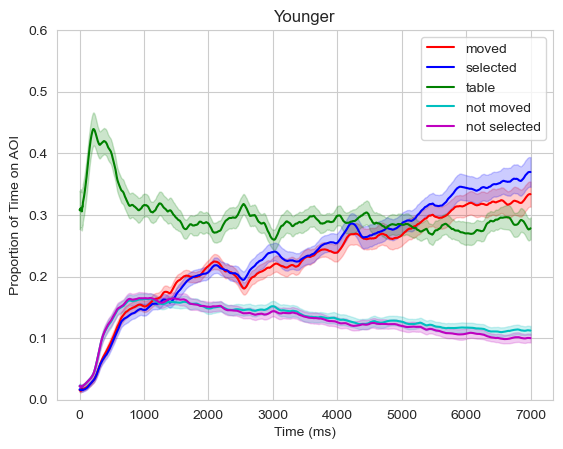

0
AUC moved:  1683.2915261304868
[0.01801012 0.01801012 0.01801012 ... 0.31329458 0.31324521 0.31320469]
1
AUC selected:  2081.6127594246036
[0.01920486 0.01920486 0.01920486 ... 0.45271865 0.4526403  0.45257422]
2
4
AUC table:  1631.157186031642
[0.29572161 0.29572161 0.29572161 ... 0.20497405 0.20491915 0.20486585]
[0.01961263 0.01961263 0.01961263 ... 0.09909086 0.09911812 0.09914133]


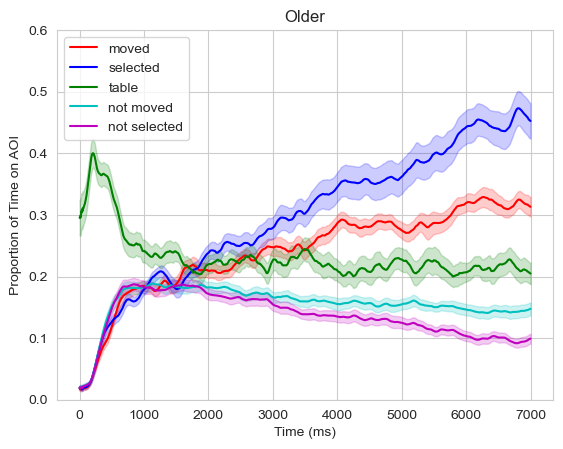

0
AUC moved:  1471.803600673186
[0.03858025 0.03858025 0.03858025 ... 0.292198   0.29206676 0.29192951]
1
AUC selected:  2043.7662684700956
[0.02623457 0.02623457 0.02623457 ... 0.50179554 0.50179253 0.5017889 ]
2
4
AUC table:  1902.549165594205
[0.36728395 0.36728395 0.36728395 ... 0.20378999 0.20393327 0.20409919]
[0.02932099 0.02932099 0.02932099 ... 0.09273475 0.09268235 0.0926316 ]


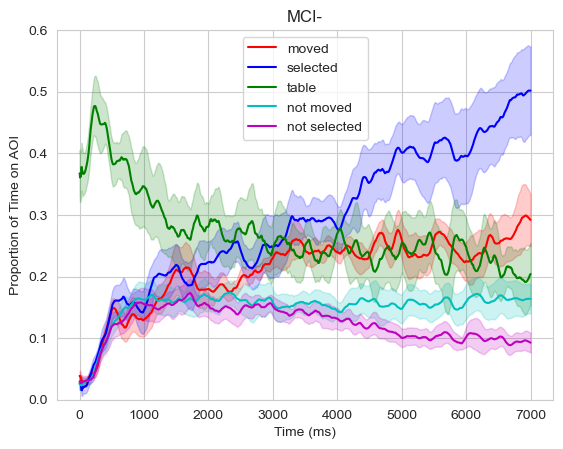

0
AUC moved:  1518.608609320691
[0.02624339 0.02624339 0.02624339 ... 0.24747906 0.2472968  0.24708304]
1
AUC selected:  2131.6560987545363
[0.0373545  0.0373545  0.0373545  ... 0.40834643 0.40811614 0.4079307 ]
2
4
AUC table:  1420.7296010189216
[0.30857143 0.30857143 0.30857143 ... 0.21059128 0.21049774 0.21025982]
[0.01918871 0.01918871 0.01918871 ... 0.10979937 0.10989641 0.10997722]


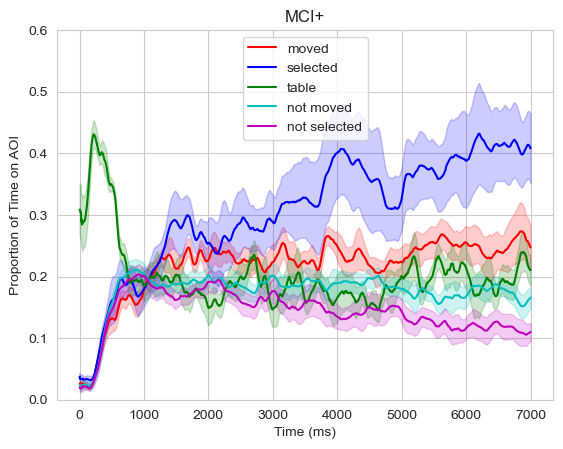

In [44]:
# plot aoi time dynamics per group
error_alpha = 0.07
for p in range(len(pid_groups)):
    pids = pid_groups[p]
    if group_names[p] == 'MCIu':
        continue
    all_ps = grouped_all_ps[p]
    labels = ['moved', 'selected','previous_pos', 'external', 'table', 'objs2-4']

    n = len(pids)
    ax = plt.figure().add_subplot()
    colors = itertools.cycle(["r", "b", "g", "c", "m", "y"])
    error_alpha = 0.2
    for i in [0, 1, 2, 4]:
        print(i)
        if view_type == 'enc' and labels[i] == 'previous_pos':
            continue
        plot_time_ps(all_ps[i], n, next(colors), labels[i], ax, alpha=error_alpha)
        # ps = all_ps[i]
        # color = next(colors)
        # means = np.mean(ps, axis=0)
        # stds = np.std(ps, axis=0)
        # ses = stds / np.sqrt(n)
        # uppers = means + ses
        # lowers = means - ses
        # ax.plot(means, c=color, label=labels[i])
        # # ax.plot(uppers, c=color, alpha=error_alpha)
        # # ax.plot(lowers, c=color, alpha=error_alpha)
        # ax.fill_between(np.arange(len(means)), uppers, lowers, alpha=0.3, color=color)
    objs2to4_means = []
    objs2to4_ses = []
    not_selected_means = []
    not_selected_ses = []
    for i in [5, 6, 7]:
        ps = all_ps[i]
        means = np.mean(ps, axis=0)
        stds = np.std(ps, axis=0)
        ses = stds / np.sqrt(n)
        objs2to4_means.append(means)
        objs2to4_ses.append(ses)
    means = np.mean(objs2to4_means, axis=0)
    ses = np.mean(objs2to4_ses, axis=0)
    color = next(colors)
    uppers = means + ses
    lowers = means - ses
    ax.plot(means, c=color, label='not moved')
    # ax.plot(uppers, c=color, alpha=error_alpha)
    # ax.plot(lowers, c=color, alpha=error_alpha)
    ax.fill_between(np.arange(len(means)), uppers, lowers, alpha=error_alpha, color=color)
    for i in [8, 9, 10]:
        ps = all_ps[i]
        means = np.mean(ps, axis=0)
        stds = np.std(ps, axis=0)
        ses = stds / np.sqrt(n)
        not_selected_means.append(means)
        not_selected_ses.append(ses)
    means = np.mean(not_selected_means, axis=0)
    ses = np.mean(not_selected_ses, axis=0)
    color = next(colors)
    uppers = means + ses
    lowers = means - ses
    ax.plot(means, c=color, label='not selected')
    # ax.plot(uppers, c=color, alpha=error_alpha)
    # ax.plot(lowers, c=color, alpha=error_alpha)
    print(means)
    ax.fill_between(np.arange(len(means)), uppers, lowers, alpha=error_alpha, color=color)
    # Add labels and legend
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Proportion of Time on AOI')
    ax.set_title(group_names[p])
    ax.set_ylim([0, 0.6])
    ax.legend()
    plt.show()
    # axes.append(ax)

AUC Younger:  1590.0244428887793
AUC Older:  1683.2915261304868
AUC MCI-:  1471.803600673186
AUC MCI+:  1518.608609320691


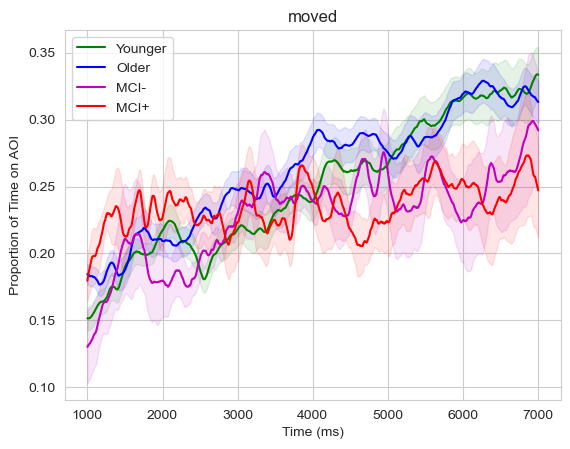

AUC Younger:  1655.7134502895979
AUC Older:  2081.6127594246036
AUC MCI-:  2043.7662684700956
AUC MCI+:  2131.6560987545363


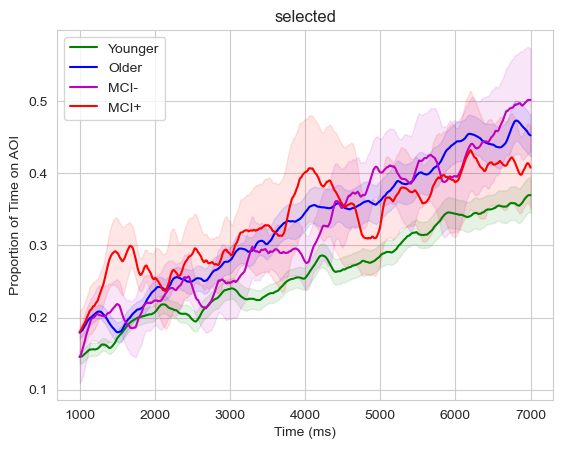

AUC Younger:  130.9841729243826
AUC Older:  68.99491403165445
AUC MCI-:  62.9425998624474
AUC MCI+:  41.549077414004785


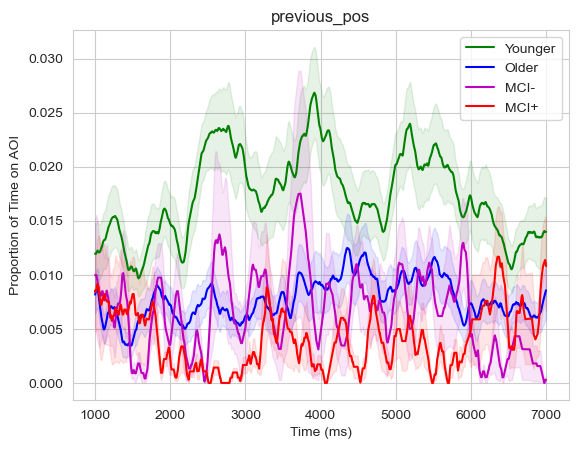

AUC Younger:  2089.094620606181
AUC Older:  1631.157186031642
AUC MCI-:  1902.549165594205
AUC MCI+:  1420.7296010189216


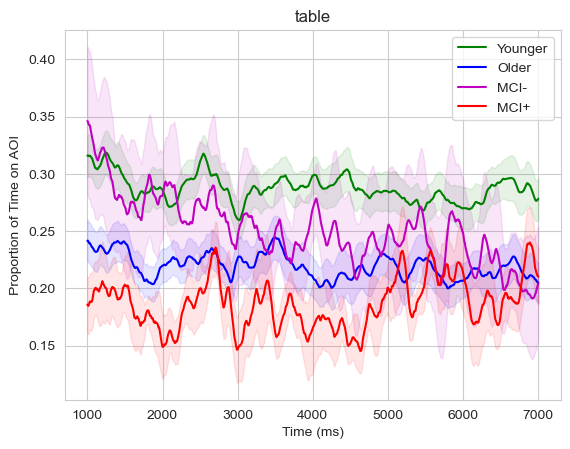

In [18]:

# plot group differences in time dynamics per aoi
    
labels = ['moved', 'selected', 'previous_pos', 'external', 'table', 'obj2', 'obj3', 'obj4', 'ns_1', 'ns_2', 'ns_3']

error_alpha = 0.1
for i in [0, 1, 2, 4]:
    ax = plt.figure().add_subplot()
    colors = itertools.cycle(["g", "b", "m", "r", "c"])
    # for p in range(len(pid_groups)):
    for p in [0, 1, 3, 4]:
        pids = pid_groups[p]
        all_ps = grouped_all_ps[p]
        plot_time_ps(all_ps[i], len(pids), next(colors), group_names[p], ax, alpha=error_alpha,
                     start_time=1000)

    # Add labels and legend
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Proportion of Time on AOI')
    ax.set_title(labels[i])
    ax.legend()
    plt.show()
    # axes.append(ax)


C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_16228\2175505155.py:36: RuntimeWarning: divide by zero encountered in log
  selected_table_logOR = np.log(selected_table_OR)
C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_16228\2175505155.py:39: RuntimeWarning: divide by zero encountered in log
  moved_x_table_ps.append(np.log(moved_odds / table_odds))
C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_16228\2175505155.py:35: RuntimeWarning: invalid value encountered in divide
  selected_table_OR = selected_odds / table_odds
C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_16228\2175505155.py:39: RuntimeWarning: invalid value encountered in divide
  moved_x_table_ps.append(np.log(moved_odds / table_odds))


AUC Younger:  499.07017771740175
AUC Younger:  -65.68900740081868
AUC Younger:  433.38117031658305
AUC Older:  -52.1343400988448
AUC Older:  -398.32123329411706
AUC Older:  -450.4555733929619
AUC MCI-:  430.7455649210188
AUC MCI-:  -571.9626677969093
AUC MCI-:  -141.2171028758906
AUC MCI+:  -97.87900830176942
AUC MCI+:  -613.0474894338452
AUC MCI+:  -710.9264977356146


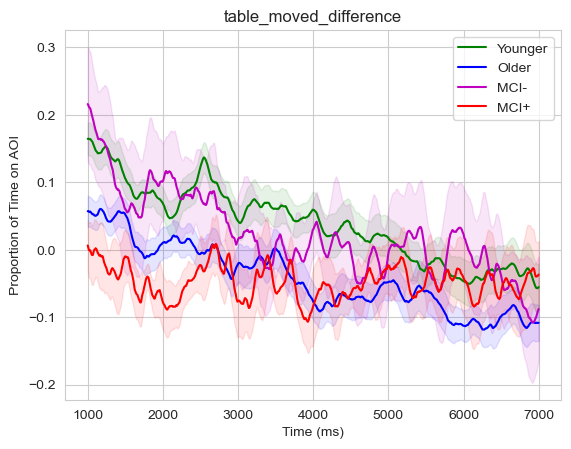

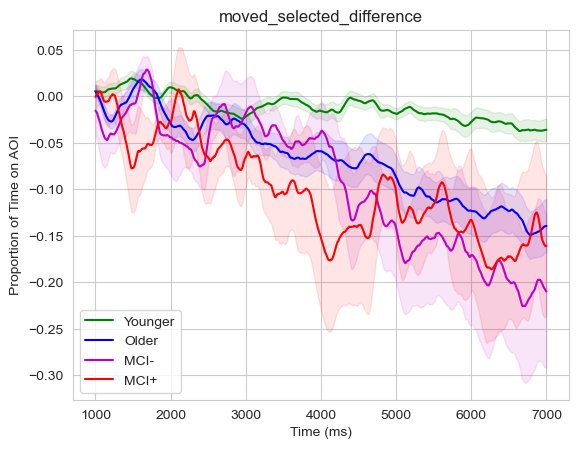

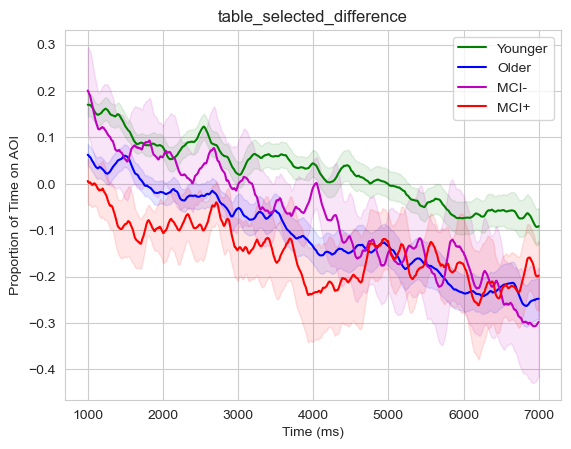

In [19]:

error_alpha = 0.1
ratio_labels = ['table_moved_difference', 'moved_selected_difference', 'table_selected_difference']
log_add = 0.0
ax = plt.figure().add_subplot()
ax2 = plt.figure().add_subplot()
ax3 = plt.figure().add_subplot()
colors = itertools.cycle(["g", "b", "m", "r", "c"])
for p in [0, 1, 3, 4]:

    pids = pid_groups[p]
    all_ps = grouped_all_ps[p]
    moved_ps = all_ps[0]
    selected_ps = all_ps[1]
    previous_ps = all_ps[2]
    table_ps = all_ps[4]

    moved_x_table_ps = []
    selected_table_logOR_ps = []
    moved_table_diff = []
    selected_moved_diff = []
    selected_table_diff = []
    interaction_ps = []

    for pi in range(len(moved_ps)):
        # print(len(moved_ps[pi]))
        # print('moved p preadd', moved_ps[pi][:5])

        moved_p = np.array(moved_ps[pi])
        selected_p = np.array(selected_ps[pi])
        previous_p = np.array(previous_ps[pi])
        table_p = np.array(table_ps[pi])
        moved_odds = moved_p / (1 - moved_p)
        selected_odds = selected_p / (1 - selected_p)
        table_odds = table_p / (1 - table_p)
        selected_table_OR = selected_odds / table_odds
        selected_table_logOR = np.log(selected_table_OR)
        interaction_p = moved_p * selected_p * previous_ps * table_p
        interaction_ps.append(interaction_p)
        moved_x_table_ps.append(np.log(moved_odds / table_odds))
        # selected_table_logOR_ps.append(moved_p - table_p)
        moved_table_diff.append(table_p - moved_p)
        selected_moved_diff.append(moved_p - selected_p)
        selected_table_diff.append(table_p - selected_p)

    # plot_time_ps(selected_moved_diff, len(pids), next(colors), group_names[p], ax)
    c = next(colors)
    plot_time_ps(moved_table_diff, len(pids), c, group_names[p], ax, start_time=1000)
    plot_time_ps(selected_moved_diff, len(pids), c, group_names[p], ax2, start_time=1000)
    plot_time_ps(selected_table_diff, len(pids), c, group_names[p], ax3, start_time=1000)

# Add labels and legend
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Proportion of Time on AOI')
ax.set_title(ratio_labels[0])
# ax.set_ylim([-2, 2])
ax.legend()

# Add labels and legend
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Proportion of Time on AOI')
ax2.set_title(ratio_labels[1])
# ax.set_ylim([-2, 2])
ax2.legend()

# Add labels and legend
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Proportion of Time on AOI')
ax3.set_title(ratio_labels[2])
# ax.set_ylim([-2, 2])
ax3.legend()

plt.show()


In [ ]:
error_alpha = 0.1
ratio_labels = ['moved+table / not moved', 'log (moved+table / notmoved)']
log_add = 0.0
ax = plt.figure().add_subplot()
colors = itertools.cycle(["g", "r", "b", "m", "c"])
# for p in range(len(pid_groups)):
for p in [0, 1, 3, 4]:
    pids = pid_groups[p]
    all_ps = grouped_all_ps[p]
    moved_ps = all_ps[0]
    selected_ps = all_ps[1]
    table_ps = all_ps[4]
    obj2_ps = all_ps[5]
    obj3_ps = all_ps[6]
    obj4_ps = all_ps[7]
    movedtable_notmoved_ratios = []
    movedtable_notmoved_logratios = []
    for pi in range(len(moved_ps)):

        # print(len(moved_ps[pi]))
        # print('moved p preadd', moved_ps[pi][:5])

        moved_p = np.array(moved_ps[pi])  + log_add
        selected_p = np.array(selected_ps[pi]) + log_add
        # print(moved_p[:5])
        table_p = np.array(table_ps[pi]) + log_add
        obj2_p = np.array(obj2_ps[pi]) + log_add
        obj3_p = np.array(obj3_ps[pi]) + log_add
        obj4_p = np.array(obj4_ps[pi]) + log_add
        movedtable_p = np.nansum(np.stack([moved_p, table_p], axis=1), axis=1)
        notmoved_p = np.nansum(np.stack([obj2_p, obj3_p, obj4_p], axis=1), axis=1)
        # print(movedtable_p[:5])
        # print(notmoved_p[:5])
        movedtable_notmoved_ratio = movedtable_p / notmoved_p
        # print(movedtable_notmoved_ratio[5000:5005])
        # print(np.log(movedtable_notmoved_ratio[5000:5005]))
        movedtable_notmoved_ratios.append(movedtable_notmoved_ratio)
        movedtable_notmoved_logratios.append(np.log(movedtable_notmoved_ratio))

    plot_time_ps(movedtable_notmoved_logratios, len(pids), next(colors), group_names[p], ax, error_alpha)

# Add labels and legend
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Proportion of Time on AOI')
ax.set_title(ratio_labels[1])
ax.legend()
plt.show()
# axes.append(ax)

In [ ]:
import numpy as np
from scipy import stats
%matplotlib widget
import matplotlib.pyplot as plt

# Assuming group1 and group2 are your data
group1 = np.random.rand(10, 500)  # 10 participants, 500 time bins
group2 = np.random.rand(10, 500)

# Calculate t-tests for each time bin
t_values, p_values = stats.ttest_ind(group1, group2, axis=0)

# Calculate standard errors for each time bin
se_group1 = stats.sem(group1, axis=0)
se_group2 = stats.sem(group2, axis=0)

# Plot t-values over time
plt.figure(figsize=(10, 5))
plt.plot(t_values, label='t-values')
plt.fill_between(range(len(t_values)), t_values-se_group1, t_values+se_group1, color='blue', alpha=0.2)
plt.fill_between(range(len(t_values)), t_values-se_group2, t_values+se_group2, color='red', alpha=0.2)
plt.xlabel('Time bin')
plt.ylabel('t-value')
plt.legend()
plt.show()

In [38]:
# hierarchical mixed model group ~ time*object + hierarchical nesting
from src.d03_processing.aoi import convert_AOIs
start_time = 800 # ms
end_time = 7000 #ms
time_freq = 50 #ms time bins for speed
master_df = None

# get data
for p in range(len(pid_groups)):
    pids = pid_groups[p]
    print(f"group {group_names[p]}")
    for pid in pids:
        # pid = '39'
        print(f"adding data for {pid} in {group_names[p]} group")
        timepoints = fetch_timepoints(pid, ret_epochs=['view'], suppress_print=True)
        trials = fetch_trials(pid, suppress_print=True)

        p_tps = []
        viewings = list(np.unique(timepoints.viewing_id))
        n_viewings = len(viewings)

        # preprocess
        for i in range(n_viewings):
            # ind = random.randint(0, len(viewings)-1)
            viewing = viewings[i]
            # viewing = "alloeye_52r2_17_ret"
            # print(viewing)

            # print(viewing)
            tps = timepoints[timepoints.viewing_id == viewing].reset_index(drop=True)
            trial = trials[trials.trial_id == viewing[:-4]].reset_index(drop=True)
            f_tps, skip = preprocess_timepoints(tps)
            if skip:
                p_tps.append(None)
            f_tps = convert_AOIs(f_tps, trial=trial, object_column='gaze_object')
            # print(np.unique(f_tps.gaze_object))
            p_tps.append(f_tps)

        # up sample and normalise time period
        up_objects = []
        max_t = 0  # starts low but gets overwritten
        min_t = 10000   # starts high but gets overwritten
        val_n_viewings = n_viewings
        val_viewings = []
        for i in range(n_viewings):
            if p_tps[i] is None:
                val_n_viewings -= 1
                continue
            else:
                val_viewings.append(viewings[i])
            t = p_tps[i].eye_timestamp_ms.to_numpy()
            end_t = np.max(t) - np.min(t)
            if end_t > max_t:
                max_t = end_t
            if end_t < min_t:
                min_t = end_t
            up_t = SignalProcessor(None, t).up_t(1)
            object_array = p_tps[i].gaze_object
            object_array[p_tps[i].missing == True] = None  # account for missingness
            upped_object= upsample_1d_string(object_array, t, 1)
            up_objects.append(upped_object)
        # print(p_tps)
        print("number of valid viewings: ", val_n_viewings)
        if val_n_viewings < 2:
            continue
        # print(len(up_objects))
        # print(max_t)
        # print(min_t)

        participant_df = None
        t = np.arange(start_time, end_time, time_freq)

        # print(len(t))
        for i in range(val_n_viewings):
            df = pd.DataFrame()
            df['t'] = t
            upped = up_objects[i]
            up_len = len(upped)
            # print(up_len)
            if up_len < end_time:
                none_len = max_t - up_len
                # print(none_len)
                up_objects[i] = np.append(up_objects[i], np.empty(none_len, dtype='object'))
            df['object'] = up_objects[i][start_time:end_time:time_freq]
            df['viewing'] = np.repeat(val_viewings[i], len(t))
            df['trial'] = np.repeat(val_viewings[i][:-4], len(t))
            df['participant'] = np.repeat(pid, len(t))
            df['group'] = np.repeat(group_names[p], len(t))
            participant_df = df if master_df is None else pd.concat([participant_df, df], ignore_index=True).reset_index(drop=True)
        master_df = participant_df if master_df is None else pd.concat([master_df, participant_df], ignore_index=True).reset_index(drop=True)
            # print(f'v{i}_obj')
master_df.to_csv("object_time_dynamics.csv")

group Younger
adding data for alloeye_5 in Younger group
dataframe returned in 1.279808521270752
number of valid viewings:  52
adding data for alloeye_6 in Younger group
dataframe returned in 0.9521541595458984
number of valid viewings:  54
adding data for alloeye_10 in Younger group
dataframe returned in 0.8939480781555176
number of valid viewings:  54
adding data for alloeye_12 in Younger group
dataframe returned in 0.9060094356536865
number of valid viewings:  54
adding data for alloeye_13 in Younger group
dataframe returned in 0.8559379577636719
number of valid viewings:  53
adding data for alloeye_14 in Younger group
dataframe returned in 0.8301262855529785
number of valid viewings:  51
adding data for alloeye_15 in Younger group
dataframe returned in 0.8740782737731934
number of valid viewings:  54
adding data for alloeye_16 in Younger group
dataframe returned in 0.8117759227752686
number of valid viewings:  54
adding data for alloeye_17 in Younger group
dataframe returned in 0.8

In [36]:
df = pd.read_csv("object_time_dynamics.csv")
# df = master_df
df = df = df[~pd.isnull(df['object'])].reset_index(drop=True)
df = df.mask(df.eq('None')).dropna().reset_index(drop=True)
# print(df.head(10))
# df = df.drop('Unnamed: 0', axis=1).reset_index(drop=True)

In [37]:
print(df.shape)
display(df[6675:6678].style)
# for col in df.columns:
#     print(np.unique(df[col]))
objects = []
for i in range(len(df)):
    if df.object[i] not in objects:
        print(df.object[i])
        objects.append(df.object[i])

(26584, 7)


,Unnamed: 0,t,object,viewing,trial,participant,group
6675,6716,1800,Obj4,alloeye_78r3_9_ret,alloeye_78r3_9,alloeye_78,Older
6676,6717,1850,Obj4,alloeye_78r3_9_ret,alloeye_78r3_9,alloeye_78,Older
6677,6718,1900,Obj4,alloeye_78r3_9_ret,alloeye_78r3_9,alloeye_78,Older


Table
Previous
Obj2
Obj3
Moved
External
Obj4


In [16]:
import statsmodels
from statsmodels.formula.api import mixedlm

# Fit hierarchical mixed model
formula = 'group ~ t*object'  # Specify the fixed effects

vc = {'trial': '0 + C(trial)'}
df.t = df.t.astype('int')
df.object = df.object.astype('category')
df.viewing = df.viewing.astype('category')
df.trial = df.trial.astype('category')
df.participant = df.participant.astype('category')
df.group = df.group.astype('category')

# print(df.dtypes)
# for column in df.columns:
#     print('#####################################################')
#     print(column)
#     print(df[column].value_counts())



model = mixedlm(formula, vc_formula=vc, re_formula='1', groups='participant', data=df)
# model = mixedlm('pids ~ distances', vc_formula=vc, re_formula='1', groups='pids', data=df)
result = model.fit()

# Print model summary
print(result.summary())

IndexError: index 6676 is out of bounds for axis 0 with size 6676